In [24]:
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import pandas as pd
import numpy as np
import json

In [25]:
with open('FRIS_data.json') as f:
    data = json.load(f)

clean_data = {}
for pro_id in data.keys():
    if data[pro_id]['publications'] and data[pro_id]['disciplines']:
        clean_data[pro_id] = data[pro_id]
print(len(clean_data))

pro_id_list = list(clean_data.keys())
for pro_id in pro_id_list:
    pubs = {}
    pro_dis_list = []
    for pub_id in clean_data[pro_id]['publications'].keys():
        if clean_data[pro_id]['publications'][pub_id]['disciplines'] and clean_data[pro_id]['publications'][pub_id]['authors']:
            pro_dis_list.extend(clean_data[pro_id]['publications'][pub_id]['disciplines'])
            pubs[pub_id] = clean_data[pro_id]['publications'][pub_id]
    
    if pubs:
        clean_data[pro_id]['publications'] = pubs
        clean_data[pro_id]['disciplines'] = list(set(pro_dis_list))
    else:
        del clean_data[pro_id]

print(len(clean_data))

444
147


In [26]:
split = 0.8
train_data = {k: clean_data[k] for k in list(clean_data.keys())[:int(split*len(clean_data))]}
test_data = {k: clean_data[k] for k in list(clean_data.keys())[int(split*len(clean_data)):]}
print(len(train_data), len(test_data))

train_project_data = {}
train_pub_data = []
for pro_id in train_data.keys():
    train_project_data[pro_id] = (train_data[pro_id]['abstract'])
    for pub_id in train_data[pro_id]['publications'].keys():
        train_pub_data.append((pub_id, train_data[pro_id]['publications'][pub_id]['abstract']))

test_project_data = {}
test_pub_data = []
for pro_id in test_data.keys():
    test_project_data[pro_id] = (test_data[pro_id]['abstract'])
    for pub_id in test_data[pro_id]['publications'].keys():
        test_pub_data.append((pub_id, test_data[pro_id]['publications'][pub_id]['abstract']))

print(len(train_project_data), len(test_project_data), len(train_pub_data), len(test_pub_data))

117 30
117 30 377 150


In [27]:
train_docs = list(train_project_data.values()) + [pub[1] for pub in train_pub_data]
test_docs = list(test_project_data.values()) + [pub[1] for pub in test_pub_data]

In [28]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(train_docs)

2024-06-16 20:03:20,451 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]
2024-06-16 20:03:27,702 - BERTopic - Embedding - Completed ✓
2024-06-16 20:03:27,702 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-06-16 20:03:29,204 - BERTopic - Dimensionality - Completed ✓
2024-06-16 20:03:29,204 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-16 20:03:29,230 - BERTopic - Cluster - Completed ✓
2024-06-16 20:03:29,235 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-16 20:03:29,315 - BERTopic - Representation - Completed ✓


In [29]:
project_abstracts = list(train_project_data.values()) + list(test_project_data.values())
pub_abstracts = [pub[1] for pub in train_pub_data] + [pub[1] for pub in test_pub_data]

project_matrix = topic_model.approximate_distribution(project_abstracts)[0]

pub_matrix = topic_model.approximate_distribution(pub_abstracts)[0]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


In [30]:
distance_matrix = np.zeros((len(project_matrix), len(pub_matrix)))

for i in range(len(project_matrix)):
    for j in range(len(pub_matrix)):
        distance_matrix[i, j] = 1 - cosine_similarity([project_matrix[i]], [pub_matrix[j]])[0][0]

distance_matrix.shape

(147, 527)

In [31]:
# gradient boosting
# data matrix is constructed as follows: rows are projects, columns are publications
# each cell is a list of 6 elements: [belongs, date, org, auth, dis, distance]
# outcome is whether publication is in project or not
# features are date, org, auth, dis, distance

# xgboost
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pylab as plt

In [32]:
# createa a dataframe with row indices as project ids and column indices as publication ids
# if publication is in project, then 1, else 0
# if publication date is before project start date, then 0, else 1
# ratio of intersection of organisations from project and publication to organisations from publication
# ratio of intersection of authors from project and publication to authors from publication
# ratio of intersection of disciplines from project and publication to disciplines from publication

pub_data = []
for pro_id in clean_data.keys():
    for pub_id in clean_data[pro_id]['publications'].keys():
        pub_data.append((pub_id, clean_data[pro_id]['publications'][pub_id]))

data_matrix = [[0.] * len(pub_data) for _ in range(len(clean_data))]
for i, pro_id in enumerate(clean_data.keys()):
    for j, pub_id in enumerate([pub[0] for pub in pub_data]):
        belongs = 1 if pub_id in clean_data[pro_id]['publications'].keys() else 0
        date = 1 if clean_data[pro_id]['start_date'] <= pub_data[j][1]['date'] else 0
        org = len(set(clean_data[pro_id]['organizations']) & set(pub_data[j][1]['organizations'])) / len(set(pub_data[j][1]['organizations']))
        auth = len(set(clean_data[pro_id]['authors']) & set(pub_data[j][1]['authors'])) / len(set(pub_data[j][1]['organizations']))
        dis = len(set(clean_data[pro_id]['disciplines']) & set(pub_data[j][1]['disciplines'])) / len(set(pub_data[j][1]['disciplines']))
        distance = distance_matrix[i, j]
        data_matrix[i][j] = [belongs, date, org, auth, dis, distance]

df = pd.DataFrame(data_matrix, index=clean_data.keys(), columns=[pub[0] for pub in pub_data])
df.to_csv('xgb_data_bertopic.csv')
df.head()

,55975b31-3cc2-4534-a097-85b1eab6cd53,bbaf834d-f8e1-4187-84b4-a35484625c09,50ad741e-6c36-4fbb-9b48-0fa901e9f63b,383f820f-0e0c-4aee-bfb4-6ebd5f6c2b63,ca3fcf40-66cf-44cd-a51e-3cff9e189cf5,d0399103-8325-4b32-9476-3d3729793829,ae73aff3-91db-470d-bc96-ea6d2e9fe137,d640f97c-94eb-4330-9772-f19d23865d19,db848229-540e-455a-baf4-55a73676b869,8a4dc512-1865-45f1-90d6-aeb015495ac1,...,1345f834-90ee-4410-9e95-64056dc7ccc6,0eff44f1-f239-4c33-8689-fbb804a0b4be,e1e2e876-911f-4b18-b306-abbcc2910cda,f3901814-7b38-44e8-9942-243712c64d0a,356a15bb-13d5-4696-b46f-1ed8c0dcc458,d7be1087-e478-45a0-8d81-e004edad4252,c9b8f2f7-64a6-4583-a3e4-e4e1ef417fcb,3479fff9-d576-4a15-8d4c-d5135a7a913e,2d806798-2da6-4083-8ae3-9aacf75687df,7fd9ea53-fad6-4203-842b-80b82bda0235
d833bf9c-e2b4-4843-a897-1eaa0baeffa6,"[1, 1, 0.0, 1.0, 1.0, 0.06646850407060301]","[1, 1, 0.0, 1.0, 1.0, 0.02869648053086238]","[1, 1, 0.25, 0.25, 1.0, 0.009798343730564874]","[1, 1, 0.0, 0.5, 1.0, 0.04750930599901071]","[1, 1, 0.0, 1.0, 1.0, 0.020194838408544413]","[1, 1, 0.0, 1.0, 1.0, 0.006953937631831386]","[0, 1, 0.0, 0.0, 1.0, 0.015287332169613643]","[0, 1, 0.0, 0.0, 0.0, 0.04827028609119033]","[0, 1, 0.0, 0.0, 1.0, 0.007024611220055821]","[0, 1, 0.0, 0.0, 0.75, 0.011573697573331598]",...,"[0, 1, 0.0, 0.0, 1.0, 0.0019249045108371554]","[0, 1, 0.0, 0.0, 0.75, 0.0018336884079742655]","[0, 1, 0.0, 0.0, 0.75, 0.03930419041346733]","[0, 1, 0.0, 0.0, 1.0, 0.024918737679733294]","[0, 1, 0.0, 0.0, 1.0, 0.014762970449704094]","[0, 1, 0.0, 0.0, 1.0, 0.007581998918402277]","[0, 1, 0.0, 0.0, 0.0, 0.03570253441190052]","[0, 1, 0.0, 0.0, 1.0, 0.009551456662318492]","[0, 1, 0.0, 0.0, 1.0, 0.005764010630306293]","[0, 1, 0.0, 0.0, 1.0, 0.026252631927340064]"
9cc34d7b-2607-4aa5-89ea-4e33cf69f92d,"[0, 1, 0.0, 0.0, 0.0, 0.0527537850595331]","[0, 1, 0.0, 0.0, 0.0, 0.01893025916984814]","[0, 1, 0.0, 0.0, 1.0, 0.003303335023329579]","[0, 1, 0.0, 0.0, 0.0, 0.04999276482506165]","[0, 1, 0.0, 0.0, 0.0, 0.01041473111010327]","[0, 1, 0.0, 0.0, 0.0, 0.006871039558756786]","[1, 1, 0.5, 0.5, 1.0, 0.0024756038852031814]","[0, 1, 0.0, 0.0, 0.0, 0.027064819711894783]","[0, 1, 0.0, 0.0, 1.0, 0.0005091522740214849]","[0, 1, 0.0, 0.0, 0.0, 0.0019416137136902822]",...,"[0, 1, 0.0, 0.0, 0.0, 0.01299797228750832]","[0, 1, 0.0, 0.0, 0.0, 0.007549484570351206]","[0, 1, 0.0, 0.0, 0.0, 0.019706296681146318]","[0, 1, 0.0, 0.0, 0.0, 0.022336902039894024]","[0, 1, 0.0, 0.0, 0.0, 0.012908468955401764]","[0, 1, 0.0, 0.0, 0.0, 0.0003192773498403856]","[0, 1, 0.0, 0.0, 0.0, 0.06919258404422512]","[0, 1, 0.0, 0.0, 0.0, 0.005949029014844509]","[0, 1, 0.0, 0.0, 0.0, 0.0022299187463850068]","[0, 1, 0.0, 0.0, 0.0, 0.013560242411144063]"
e94c1597-1a58-4165-8fdb-d9a7f62a03ae,"[0, 1, 0.0, 0.0, 0.0, 0.03178284065846504]","[0, 1, 0.0, 0.0, 0.0, 0.02583742025370439]","[0, 1, 0.0, 0.0, 0.0, 0.01301341437311021]","[0, 1, 0.0, 0.0, 0.0, 0.04824486512460391]","[0, 1, 0.0, 0.0, 0.0, 0.013341152036282944]","[0, 1, 0.0, 0.0, 0.0, 0.028567637451829442]","[0, 1, 0.0, 0.0, 0.0, 0.016849554749234663]","[1, 1, 1.0, 1.0, 1.0, 0.008261301421745637]","[0, 1, 0.0, 0.0, 0.0, 0.01963548779012958]","[0, 1, 0.0, 0.0, 0.0, 0.019670827605551278]",...,"[0, 1, 0.0, 0.0, 0.0, 0.04633332267816992]","[0, 1, 0.0, 0.0, 0.0, 0.03245326113514024]","[0, 1, 0.0, 0.0, 0.0, 0.007058198910721236]","[0, 0, 0.0, 0.0, 0.0, 0.026874459046633103]","[0, 0, 0.0, 0.0, 0.0, 0.026116657296919588]","[0, 0, 0.0, 0.0, 0.0, 0.017811068687825116]","[0, 0, 0.0, 0.0, 0.0, 0.13981648904672672]","[0, 1, 0.0, 0.0, 0.0, 0.03506634551561727]","[0, 1, 0.0, 0.0, 0.0, 0.017868178990686268]","[0, 1, 0.0, 0.0, 0.0, 0.03780102977546407]"
4c845bc0-4c79-4105-a2c9-09fbe5275fbd,"[0, 1, 0.0, 0.0, 0.0, 0.027325877278912225]","[0, 1, 0.0, 0.0, 0.0, 0.004244317075812631]","[0, 1, 0.0, 0.0, 1.0, 0.003667470289518082]","[0, 1, 0.0, 0.0, 0.0, 0.032458307954457144]","[0, 1, 0.0, 0.0, 0.0, 0.0005837589194485071]","[0, 1, 0.0, 0.0, 0.0, 0.004014811904516469]","[0, 1, 0.0, 0.0, 1.0, 0.015038120943478561]","[0, 1, 0.0, 0.0, 0.0, 

In [33]:
gb_raw_shape = (df.shape[0], df.shape[1], len(df.iloc[0, 0]))
print(gb_raw_shape)

gb_data = []
for i in range(len(list(df))):
    gb_data.extend(df.iloc[:, i].values.tolist())
gb_data = np.array(gb_data)
print(gb_data.shape)

project_numbers = np.array(list(range(1, gb_raw_shape[0] + 1)) * gb_raw_shape[1])
# gb_data = np.hstack((gb_data, project_numbers))
# gb_data

(147, 527, 6)
(77469, 6)


In [34]:
# get the projects for lowest predictions for each publication with distance matrix
for num_top in range(10, 0, -1):
    project_numbers_pred = []
    for i in range(len(train_pub_data), distance_matrix.shape[1]):
        project_numbers_pred.append(list(np.argsort(distance_matrix[:, i] + 1))[:num_top])

    project_lists = []
    for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
        pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
        project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
        project_lists.append(project)

    project_lists_test = project_lists[len(train_pub_data):]

    # calculate accuracy
    # use y_test as mask for project_numbers_test
    accuracy_list = []
    for i, project_list in enumerate(list(project_lists_test)):
        ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
        accuracy_list.append(ratio)

    accuracy = sum(accuracy_list) / len(accuracy_list)
    print(accuracy)

0.12333333333333334
0.09666666666666666
0.07666666666666666
0.06666666666666667
0.04
0.02666666666666667
0.02
0.02
0.02
0.02


In [35]:
X = gb_data[:, 1:]
y = gb_data[:, 0]

split = len(train_pub_data) * len(clean_data)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [36]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.01
}

# params_constrained = params.copy()
# params_constrained['interaction_constraints'] = '[[0, 1, 2, 3, 4]]'
feature_names = ['date criterion', 'organisation ratio', 'author ratio', 'discipline ratio', 'distance']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

num_boost_round = 10000
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round,
                      evals=[(dtest, 'test')],
                      early_stopping_rounds=200, 
                      verbose_eval=100)

[0]	test-logloss:0.14350
[100]	test-logloss:0.05698
[200]	test-logloss:0.02761
[300]	test-logloss:0.01702
[400]	test-logloss:0.01318
[500]	test-logloss:0.01185
[600]	test-logloss:0.01137
[700]	test-logloss:0.01119
[800]	test-logloss:0.01112
[900]	test-logloss:0.01108
[1000]	test-logloss:0.01106
[1100]	test-logloss:0.01110
[1200]	test-logloss:0.01117
[1211]	test-logloss:0.01118


In [37]:
# xgb_cv = xgb.cv(params,
#                 dtrain,
#                 num_boost_round=num_boost_round,
#                 nfold=5,
#                 early_stopping_rounds=200,
#                 verbose_eval=100)

# # plot xgb_cv
# fig, ax = plt.subplots()
# ax.plot(xgb_cv['train-logloss-mean'], label='train')
# ax.plot(xgb_cv['test-logloss-mean'], label='test')
# ax.legend()

In [38]:
# make prediction
y_pred = xgb_model.predict(dtest)

# get the projects for highest 3 predictions for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:3])

In [39]:
project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

In [40]:
# calculate accuracy
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

# get indices of accuracy_list different than 1
indices = [i for i, x in enumerate(accuracy_list) if x != 1]
print(indices)
print([project_numbers_pred[i] for i in indices])
print([project_lists_test[i] for i in indices])

0.9733333333333334
[4, 14, 22, 23]
[[23, 111, 110], [7, 124, 132], [7, 134, 123], [37, 40, 47]]
[[119], [121], [121], [121]]


In [41]:
# make two predictions for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:2])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
# use y_test as mask for project_numbers_test
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

0.9566666666666667


In [42]:
# make single prediction for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:1])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    accuracy = 1 if project_numbers_pred[i][0] in project_list else 0
    accuracy_list.append(accuracy)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

0.76


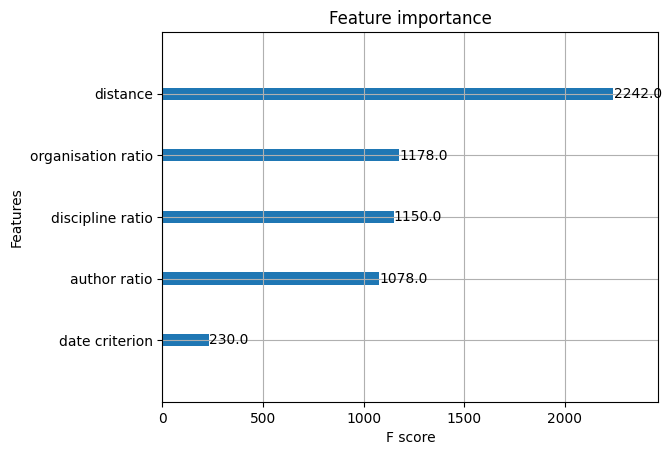

In [43]:
plot_importance(xgb_model)
plt.show()

[0]	test-logloss:0.14350
[100]	test-logloss:0.05698
[200]	test-logloss:0.02761
[300]	test-logloss:0.01703
[400]	test-logloss:0.01319
[500]	test-logloss:0.01190
[600]	test-logloss:0.01142
[700]	test-logloss:0.01123
[800]	test-logloss:0.01114
[900]	test-logloss:0.01112
[1000]	test-logloss:0.01114
[1082]	test-logloss:0.01116
0.9733333333333334


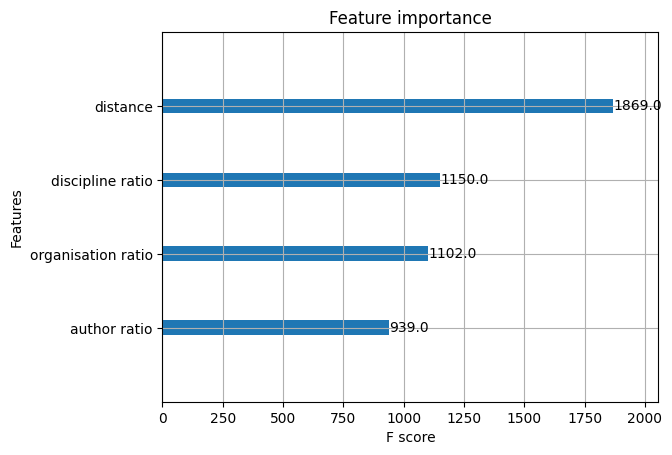

In [44]:
# drop date column
gb_data_no_date = np.delete(gb_data, 1, 1)

X = gb_data_no_date[:, 1:]
y = gb_data_no_date[:, 0]

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.01
}

# params_constrained = params.copy()
# params_constrained['interaction_constraints'] = '[[0, 1, 2, 3]]'
feature_names = ['organisation ratio', 'author ratio', 'discipline ratio', 'distance']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names, enable_categorical=True)

num_boost_round = 10000
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round, 
                      evals=[(dtest, 'test')], 
                      early_stopping_rounds=200, 
                      verbose_eval=100)

# make three predictions for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:3])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
# use y_test as mask for project_numbers_test
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

plot_importance(xgb_model)
plt.show()

[0]	test-logloss:0.14354
[100]	test-logloss:0.05858
[200]	test-logloss:0.02945
[300]	test-logloss:0.01905
[400]	test-logloss:0.01539
[500]	test-logloss:0.01408
[600]	test-logloss:0.01360
[700]	test-logloss:0.01346
[800]	test-logloss:0.01345
[900]	test-logloss:0.01344
[1000]	test-logloss:0.01347
[1085]	test-logloss:0.01350
0.9533333333333334


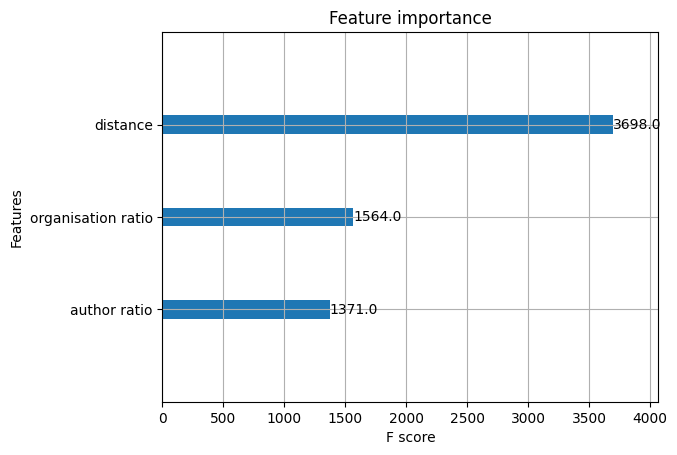

In [46]:
# drop date column
gb_data_no_date_dis = np.delete(gb_data, [1, 4], 1)

X = gb_data_no_date_dis[:, 1:]
y = gb_data_no_date_dis[:, 0]

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.01
}

# params_constrained = params.copy()
# params_constrained['interaction_constraints'] = '[[0, 1, 2, 3]]'
feature_names = ['organisation ratio', 'author ratio', 'distance']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names, enable_categorical=True)

num_boost_round = 10000
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round, 
                      evals=[(dtest, 'test')], 
                      early_stopping_rounds=200, 
                      verbose_eval=100)

# make three predictions for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
project_numbers_pred = []
for i in range(0, len(y_pred), gb_raw_shape[0]):
    project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:3])

project_lists = []
for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
    pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
    project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
    project_lists.append(project)

project_lists_test = project_lists[len(train_pub_data):]

# calculate accuracy
# use y_test as mask for project_numbers_test
accuracy_list = []
for i, project_list in enumerate(list(project_lists_test)):
    ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
    accuracy_list.append(ratio)

accuracy = sum(accuracy_list) / len(accuracy_list)
print(accuracy)

plot_importance(xgb_model)
plt.show()

[0]	test-logloss:0.13045
[100]	test-logloss:0.01130
[200]	test-logloss:0.01130
[300]	test-logloss:0.01130
[400]	test-logloss:0.01131
[500]	test-logloss:0.01132
[600]	test-logloss:0.01133
[700]	test-logloss:0.01134
[800]	test-logloss:0.01135
[900]	test-logloss:0.01136
[1000]	test-logloss:0.01137
[1100]	test-logloss:0.01138
[1108]	test-logloss:0.01138
0.9933333333333333
0.9933333333333333
0.9933333333333333
0.9866666666666667
0.98
0.9733333333333334
0.9666666666666667
0.96
0.9466666666666667
0.7133333333333334


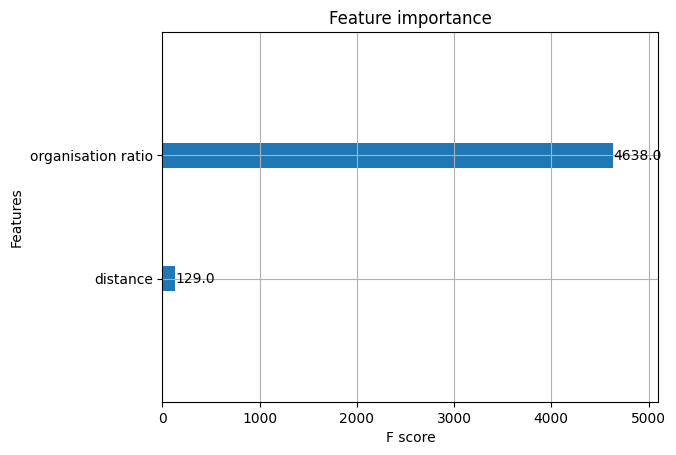

In [49]:
# only org and distance
X = gb_data[:, [2, 4]]
y = gb_data[:, 0]

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1
}

# params_constrained = params.copy()
# params_constrained['interaction_constraints'] = '[[0, 1, 2, 3]]'
feature_names = ['organisation ratio', 'distance']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names, enable_categorical=True)

num_boost_round = 10000
xgb_model = xgb.train(params, 
                      dtrain, 
                      num_boost_round, 
                      evals=[(dtest, 'test')], 
                      early_stopping_rounds=1000, 
                      verbose_eval=100)

# make three predictions for each publication
y_pred = xgb_model.predict(dtest)

# get the projects for the highest prediction for each publication
for num_top in range(10, 0, -1):
    project_numbers_pred = []
    for i in range(0, len(y_pred), gb_raw_shape[0]):
        project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:num_top])

    project_lists = []
    for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
        pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
        project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
        project_lists.append(project)

    project_lists_test = project_lists[len(train_pub_data):]

    # calculate accuracy
    # use y_test as mask for project_numbers_test
    accuracy_list = []
    for i, project_list in enumerate(list(project_lists_test)):
        ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
        accuracy_list.append(ratio)

    accuracy = sum(accuracy_list) / len(accuracy_list)
    print(accuracy)

plot_importance(xgb_model)
plt.show()

In [47]:
# support vector machine
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

X = gb_data[:, 1:]
y = gb_data[:, 0]

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
svc = SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)
print(clf.best_params_)

# make prediction
y_pred = clf.predict(X_test)

# get the projects for the highest prediction for each publication
for num_top in range(10, 0, -1):
    project_numbers_pred = []
    for i in range(0, len(y_pred), gb_raw_shape[0]):
        project_numbers_pred.append(list(np.argsort(y_pred[i:i+gb_raw_shape[0]]) + 1)[::-1][:num_top])

    project_lists = []
    for i in range(0, gb_data.shape[0], gb_raw_shape[0]):
        pub_belongs = gb_data[i:i + gb_raw_shape[0], 0] * project_numbers[i:i + gb_raw_shape[0]]
        project = sorted(list(pub_belongs[pub_belongs != 0].astype(int)), reverse=True)
        project_lists.append(project)

    project_lists_test = project_lists[len(train_pub_data):]

    # calculate accuracy
    # use y_test as mask for project_numbers_test
    accuracy_list = []
    for i, project_list in enumerate(list(project_lists_test)):
        ratio = len(set(project_numbers_pred[i]) & set(project_list)) / len(set(project_list))
        accuracy_list.append(ratio)

    accuracy = sum(accuracy_list) / len(accuracy_list)
    print(accuracy)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.21333333333333335
0.21333333333333335
0.21333333333333335
0.21333333333333335
0.21333333333333335
0.21333333333333335
0.21333333333333335
0.21333333333333335
0.20333333333333334
0.18666666666666668
